Spaceship Titanic
=================

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars. While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system. Help save them and change history!

https://www.kaggle.com/competitions/spaceship-titanic/overview

**Step 1/3 assess model with CredoAI - Lens**

In [1]:
import pandas as pd
import joblib

import warnings
warnings.filterwarnings('ignore')

from credoai.lens import Lens
from credoai.artifacts import ClassificationModel, TabularData
from credoai.evaluators import ModelFairness, Performance

# For this to work, you need to "File / Save and export notebook as... / Executable Script" the notebook
import Spaceship_Titanic_data

(train) Number of rows = 8693 and Number of cols = 14
(test) Number of rows = 4277 and Number of cols = 13


Load trained model
------------------


In [2]:
feature_engineering = Spaceship_Titanic_data.feature_engineering  # This is necessary to unpickle the model

with open('model.jlb', 'rb') as file:
    model = joblib.load(file)
    
processor = model.steps[0][1]
drop_target = model.steps[1][1]
classifier = model.steps[2][1]

fe_eng = processor.steps[0][1]
imputer = processor.steps[1][1]

Run a battery of evaluators over Age
------------------------------------

Prepare the train data for evaluation

In [3]:
transformed_data = processor.fit_transform(Spaceship_Titanic_data.train_data)
dropped_data = drop_target.fit_transform(transformed_data)

imputed_data = imputer.fit_transform(fe_eng.fit_transform(Spaceship_Titanic_data.train_data)) # Skip the scaler to get more readable results
ages = pd.qcut(imputed_data.Age, 10) # Quantize ages in 10 clusters from min age to max age

Wrap both the model and the data in CredoAI - Lens structures

In [4]:
credo_model = ClassificationModel(name="titanic_default_classifier",
                                  model_like=classifier)
credo_data = TabularData(
    name="titanic-default",
    X=dropped_data,
    y=transformed_data.Transported,
    sensitive_features=ages
)

Create a Lens and execute evaluators

In [5]:
lens = Lens(model=credo_model, assessment_data=credo_data)

# Precission score: % of true positives versus false positives https://credoai-lens.readthedocs.io/en/latest/pages/metrics.html#precision-score
# Recall score: probability of positive test if conditions are positive https://credoai-lens.readthedocs.io/en/latest/pages/metrics.html#true-positive-rate

metrics = ['precision_score', 'recall_score', 'equal_opportunity']
lens.add(ModelFairness(metrics=metrics))
lens.add(Performance(metrics=metrics))
lens.run()
None

2023-04-21 09:12:32,934 - lens - INFO - Evaluator ModelFairness added to pipeline. Sensitive feature: Age
2023-04-21 09:12:33,021 - lens - INFO - Evaluator Performance added to pipeline. 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


In [6]:
fairness_results = lens.get_results(evaluator_name='ModelFairness')[0]

aggr = fairness_results['results'][0]
disaggr = fairness_results['results'][1]

display(aggr)

,type,value
0,equal_opportunity,0.214289
0,precision_score_parity,0.100792
1,recall_score_parity,0.214289


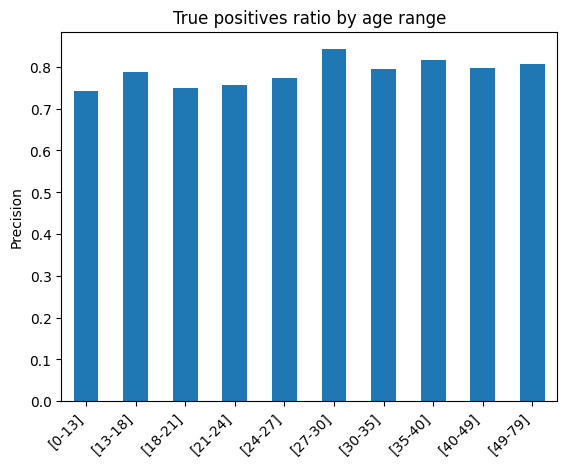

In [7]:
graph = disaggr[['Age', 'value']] \
                .head(10) \
                .rename(columns={'value': 'Precision'})

plot = graph.plot.bar(ylabel='Precision', legend=False, title='True positives ratio by age range')
plot.set_xticklabels(graph.Age.map(lambda r: f'[{int(r.left)}-{int(r.right)}]'),
                     rotation=45,
                     horizontalalignment='right')
None

In [8]:
performance_results = lens.get_results(evaluator_name='Performance')[0]
# first dataframe is overall metrics
display(performance_results['results'][0])
# second dataframe is the long form of the confusion matrix
display(performance_results['results'][1])

,type,value
0,precision_score,0.781845
1,recall_score,0.834171


,true_label,predicted_label,value
0,False,False,0.763847
1,True,False,0.165829
2,False,True,0.236153
3,True,True,0.834171


Run a simple evaluation over VIP
--------------------------------

Prepare the train data for evaluation

In [9]:
vip = imputed_data.VIP

Wrap both the model and the data in CredoAI - Lens structures

In [10]:
credo_model2 = ClassificationModel(name="titanic_default_classifier",
                                  model_like=classifier)
credo_data2 = TabularData(
    name="titanic-default",
    X=dropped_data,
    y=transformed_data.Transported,
    sensitive_features=vip
)

Create a Lens and execute evaluators

In [11]:
lens2 = Lens(model=credo_model2, assessment_data=credo_data2)

# Precission score: % of true positives versus false positives https://credoai-lens.readthedocs.io/en/latest/pages/metrics.html#precision-score
# Recall score: probability of positive test if conditions are positive https://credoai-lens.readthedocs.io/en/latest/pages/metrics.html#true-positive-rate

metrics2 = ['precision_score', 'equal_opportunity']
lens2.add(ModelFairness(metrics=metrics2))
lens2.run()
None

2023-04-21 09:12:33,448 - lens - INFO - Evaluator ModelFairness added to pipeline. Sensitive feature: VIP
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [12]:
fairness_results2 = lens2.get_results(evaluator_name='ModelFairness')[0]

aggr2 = fairness_results2['results'][0]
disaggr2 = fairness_results2['results'][1]

display(aggr2)

,type,value
0,equal_opportunity,0.018706
0,precision_score_parity,0.092805


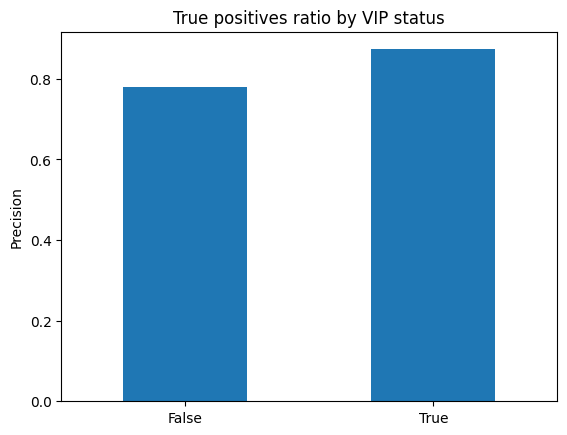

In [13]:
graph2 = disaggr2[['VIP', 'value']] \
                  .head(10) \
                  .rename(columns={'value': 'Precision'})

plot2 = graph2.plot.bar(ylabel='Precision', legend=False, title='True positives ratio by VIP status')
plot2.set_xticklabels(graph2.VIP, rotation=0)
None